In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 23.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/FDL21_RaVAEn_datasets/floods.zip" floods.zip
!unzip floods.zip
!rm floods.zip

Archive:  floods.zip
   creating: floods/
   creating: floods/EMSR333_02PORTOPALO/
   creating: floods/EMSR333_02PORTOPALO/changes_vector/
  inflating: floods/EMSR333_02PORTOPALO/changes_vector/2018-11-04.geojson  
   creating: floods/EMSR333_02PORTOPALO/S2/
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-25.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-20.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-23.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-30.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-11-04.tif  
   creating: floods/EMSR333_02PORTOPALO/cloudprob_edited_vector/
  inflating: floods/EMSR333_02PORTOPALO/cloudprob_edited_vector/2018-11-04.geojson  
   creating: floods/EMSR333_02PORTOPALO/changes/
  inflating: floods/EMSR333_02PORTOPALO/changes/2018-11-04.tif  
   creating: floods/EMSR333_02PORTOPALO/floodmap_edited/
  inflating: floods/EMSR333_02PORTOPALO/floodmap_edited/2018-11-04.geojson  
   creating: floods/EMSR271_02FARKADONA/
  

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import os
import rasterio

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class FloodDataset(nn.Module):
    def __init__(self, patch_size=64):
        super(FloodDataset, self).__init__()
        self.patch_size = patch_size
        self.patches = []
        self.precompute_patches()

    def precompute_patches(self):
        root = os.listdir("floods")
        for path in root:
            img_paths = [os.path.join("floods", path, "S2", x) for x in os.listdir(os.path.join("floods", path, "S2")) if x.endswith(".tif")]
            for img_path in img_paths:
                with rasterio.open(img_path) as src:
                    img = src.read()  # Read all bands
                height, width = img.shape[1], img.shape[2]
                for row in range(0, height, self.patch_size):
                    for col in range(0, width, self.patch_size):
                        if row + self.patch_size <= height and col + self.patch_size <= width:
                            patch = img[:, row:row + self.patch_size, col:col + self.patch_size]
                            quantiles = np.quantile(patch, [0.01, 0.99], axis=(1, 2), keepdims=True)
                            patch = (patch - quantiles[0]) / (quantiles[1] - quantiles[0]+1e-5)
                            patch = np.clip(patch, 0,1)
                            patch = torch.tensor(patch, dtype=torch.float32)
                            if not torch.isnan(patch).any():
                                self.patches.append(patch)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx]


In [3]:
ds = FloodDataset(patch_size=256)

split = 0.8
train_size = int(split * len(ds))
val_size = len(ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)



torch.Size([32, 15, 256, 256])


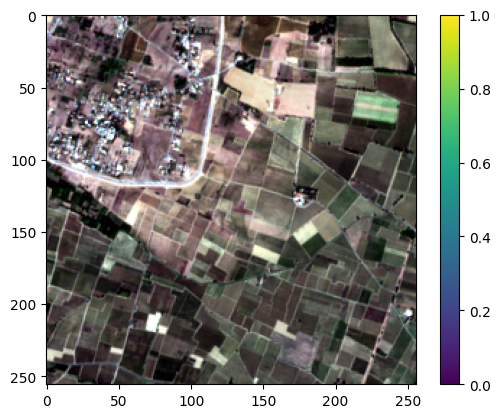

In [4]:
#Test train_loader
bands = [3,2,1]
data = next(iter(train_loader))
print(data.shape)
plt.imshow(data[0,bands,:,:].permute(1, 2, 0).numpy())
plt.colorbar()
plt.show()

In [5]:
class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()
        self.latent_size = latent_size
        self.encoder = nn.Sequential(
            nn.Conv2d(15, 32, kernel_size=3, stride=2, padding=1),  # 4 input channels (
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 32 input channels
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 64 input channels
            nn.ReLU())
        self.fc_mu = nn.Linear(128 * 8 * 8 *16, self.latent_size)
        self.fc_logvar = nn.Linear(128 * 8 * 8 * 16, self.latent_size)
        self.fc_decode = nn.Linear(self.latent_size, 128 * 8 * 8*16)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # 128 input channels
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64 input channels
            nn.ReLU(),
            nn.ConvTranspose2d(32, 15, kernel_size=8, stride=2, padding=1),  # 32 input channels
            nn.Sigmoid())
        # 4 output channels (same as input)

    def encode(self, x):
        # Define the encoder part of the VAE
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.fc_decode(z)
        z = z.view(z.size(0), 128, 8*4, 8*4)
        x = self.decoder(z)
        return x

    def forward(self, x):
        # Forward pass through the VAE
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



In [6]:
def loss_function(recon_x, x, mu, logvar, gamma):
    # Define the loss function for the VAE
    # Gamma is the variance of the prior
    D = mu.size(1)
    MSE = D*(F.mse_loss(recon_x, x, reduction='sum')/(2*gamma.pow(2)) + (gamma.log()))
    KLD = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - 1 - logvar)
    return MSE , KLD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, val_loader, gamma, optimizer, epochs):
    t_mse = []
    t_kld = []
    v_mse = []
    v_kld = []
    gamma_vals = []

    for epoch in range(epochs):
        gamma_vals.append(gamma.item())
        model.train()
        train_loss_mse = 0
        train_loss_kld = 0
        train_loss = 0
        for batch_idx, data in tqdm(enumerate(train_loader)):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            mse, kld = loss_function(recon_batch, data, mu, logvar, gamma)
            loss = mse + kld
            train_loss_kld += kld.item()
            train_loss_mse += mse.item()
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        # Append train losses to lists after each epoch
        t_mse.append(train_loss_mse / len(train_loader.dataset))
        t_kld.append(train_loss_kld / len(train_loader.dataset))

        print(f"====> Epoch: {epoch} Average loss: {(train_loss) / len(train_loader.dataset):.4f}")

        val_loss_mse = 0
        val_loss_kld = 0
        val_loss = 0
        for batch_idx ,data in enumerate(val_loader):
            model.eval()
            data = data.to(device)
            with torch.no_grad():
                recon_batch, mu, logvar = model(data)
                mse, kld = loss_function(recon_batch, data, mu, logvar, gamma)
                v_loss = mse + kld
                val_loss_kld += kld.item()
                val_loss_mse += mse.item()
                val_loss += v_loss.item()
        # Append val losses to lists after each epoch
        v_mse.append(val_loss_mse / len(val_loader.dataset))
        v_kld.append(val_loss_kld / len(val_loader.dataset))

        print(f"====> Validation loss: {(val_loss) / len(val_loader.dataset):.4f}")

    return t_mse, t_kld, v_mse, v_kld, gamma_vals

In [8]:
model = VAE(latent_size=1024).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
gamma = torch.tensor([1.]).to(device)
gamma.requires_grad = True
optimizer.add_param_group({'params': gamma})
t_mse, t_kld, v_mse, v_kld, gamma_vals = train(model, train_loader, val_loader, gamma, optimizer, epochs=100)

[{'params': [Parameter containing:
tensor([[[[-0.0046,  0.0070, -0.0728],
          [-0.0744,  0.0674, -0.0172],
          [ 0.0126, -0.0036, -0.0013]],

         [[-0.0381,  0.0527, -0.0294],
          [ 0.0386,  0.0644,  0.0234],
          [-0.0107, -0.0403,  0.0027]],

         [[ 0.0481,  0.0178, -0.0859],
          [-0.0295, -0.0315,  0.0570],
          [ 0.0514,  0.0602,  0.0822]],

         ...,

         [[ 0.0385,  0.0666, -0.0408],
          [ 0.0116, -0.0684, -0.0013],
          [ 0.0792,  0.0601,  0.0846]],

         [[-0.0471,  0.0108,  0.0500],
          [-0.0651, -0.0041,  0.0419],
          [ 0.0447, -0.0111, -0.0662]],

         [[-0.0384, -0.0386,  0.0851],
          [ 0.0359, -0.0468, -0.0726],
          [-0.0715, -0.0385,  0.0649]]],


        [[[-0.0142, -0.0258,  0.0321],
          [-0.0444,  0.0137, -0.0299],
          [ 0.0078, -0.0076,  0.0491]],

         [[ 0.0029, -0.0702,  0.0539],
          [ 0.0685, -0.0115, -0.0242],
          [ 0.0415, -0.0138,  0.0067]

16it [00:04,  3.28it/s]

====> Epoch: 0 Average loss: 34570649.6250


====> Validation loss: 26263124.0000


16it [00:04,  3.55it/s]


====> Epoch: 1 Average loss: 25581069.2500
====> Validation loss: 23760228.5000


16it [00:04,  3.34it/s]

====> Epoch: 2 Average loss: 23655329.2500


====> Validation loss: 22094348.0000


16it [00:04,  3.63it/s]

====> Epoch: 3 Average loss: 21757504.2500


====> Validation loss: 20925307.0000


16it [00:04,  3.35it/s]

====> Epoch: 4 Average loss: 20236067.5000


====> Validation loss: 19442940.0000


16it [00:04,  3.82it/s]

====> Epoch: 5 Average loss: 18796692.8750


====> Validation loss: 17843043.5000


16it [00:04,  3.30it/s]

====> Epoch: 6 Average loss: 16741353.3750


====> Validation loss: 16012303.5000


16it [00:04,  3.66it/s]

====> Epoch: 7 Average loss: 15273851.8125


====> Validation loss: 15112079.7500


16it [00:04,  3.48it/s]


====> Epoch: 8 Average loss: 14106070.0000
====> Validation loss: 14119260.0000


16it [00:04,  3.49it/s]

====> Epoch: 9 Average loss: 13074759.7500


====> Validation loss: 13309240.5000


16it [00:04,  3.65it/s]

====> Epoch: 10 Average loss: 12062813.6250


====> Validation loss: 12461724.2500


16it [00:04,  3.27it/s]

====> Epoch: 11 Average loss: 11169540.8750


====> Validation loss: 11512644.0000


16it [00:04,  3.62it/s]

====> Epoch: 12 Average loss: 10058603.3750


====> Validation loss: 10566501.2500


16it [00:04,  3.42it/s]

====> Epoch: 13 Average loss: 9224121.6875


====> Validation loss: 9976804.7500


16it [00:04,  3.65it/s]

====> Epoch: 14 Average loss: 8475073.0625


====> Validation loss: 9363791.2500


16it [00:04,  3.62it/s]

====> Epoch: 15 Average loss: 7751511.9375


====> Validation loss: 8564515.0000


16it [00:04,  3.28it/s]

====> Epoch: 16 Average loss: 7101185.6250


====> Validation loss: 8159026.1250


16it [00:04,  3.59it/s]

====> Epoch: 17 Average loss: 6561092.5000


====> Validation loss: 7591636.1250


16it [00:04,  3.39it/s]

====> Epoch: 18 Average loss: 6082868.6875


====> Validation loss: 7317215.6250


16it [00:04,  3.64it/s]

====> Epoch: 19 Average loss: 5689243.5312


====> Validation loss: 7009008.3750


16it [00:04,  3.60it/s]

====> Epoch: 20 Average loss: 5245171.3438


====> Validation loss: 6634712.3750


16it [00:04,  3.39it/s]

====> Epoch: 21 Average loss: 4959298.5938


====> Validation loss: 6666005.5000


16it [00:04,  3.64it/s]

====> Epoch: 22 Average loss: 4790423.8438


====> Validation loss: 6292115.8750


16it [00:04,  3.32it/s]

====> Epoch: 23 Average loss: 4459436.5781


====> Validation loss: 6052784.3750


16it [00:04,  3.62it/s]

====> Epoch: 24 Average loss: 4193699.3281


====> Validation loss: 5908714.6250


16it [00:04,  3.53it/s]

====> Epoch: 25 Average loss: 3996697.2344


====> Validation loss: 5776001.5000


16it [00:04,  3.57it/s]

====> Epoch: 26 Average loss: 3838471.0312


====> Validation loss: 5909308.3750


16it [00:05,  3.15it/s]

====> Epoch: 27 Average loss: 3800492.3438


====> Validation loss: 5649757.7500


16it [00:04,  3.29it/s]

====> Epoch: 28 Average loss: 3597204.4688


====> Validation loss: 5549446.6250


16it [00:04,  3.59it/s]

====> Epoch: 29 Average loss: 3541388.5625


====> Validation loss: 5500132.2500


16it [00:04,  3.25it/s]

====> Epoch: 30 Average loss: 3373073.6250


====> Validation loss: 5299934.8750


16it [00:04,  3.61it/s]

====> Epoch: 31 Average loss: 3214876.6406


====> Validation loss: 5280674.2500


16it [00:04,  3.55it/s]

====> Epoch: 32 Average loss: 3103485.9844


====> Validation loss: 5172665.2500


16it [00:04,  3.50it/s]

====> Epoch: 33 Average loss: 2965110.1875


====> Validation loss: 5089603.1250


16it [00:04,  3.63it/s]

====> Epoch: 34 Average loss: 2864447.8125


====> Validation loss: 5033273.2500


16it [00:05,  3.10it/s]

====> Epoch: 35 Average loss: 2772593.9531


====> Validation loss: 5006476.7500


16it [00:04,  3.58it/s]

====> Epoch: 36 Average loss: 2689861.5938


====> Validation loss: 4958395.0000


16it [00:04,  3.37it/s]


====> Epoch: 37 Average loss: 2634584.6719
====> Validation loss: 4933041.8750


16it [00:04,  3.60it/s]

====> Epoch: 38 Average loss: 2588894.2344


====> Validation loss: 4902297.3750


16it [00:04,  3.54it/s]

====> Epoch: 39 Average loss: 2590681.5000


====> Validation loss: 4894909.3750


16it [00:04,  3.30it/s]

====> Epoch: 40 Average loss: 2523223.2500


====> Validation loss: 4816247.5000


16it [00:04,  3.59it/s]

====> Epoch: 41 Average loss: 2413053.2969


====> Validation loss: 4770052.7500


16it [00:05,  3.13it/s]

====> Epoch: 42 Average loss: 2329809.4531


====> Validation loss: 4714820.5000


16it [00:04,  3.60it/s]

====> Epoch: 43 Average loss: 2280615.8672


====> Validation loss: 4715988.6250


16it [00:04,  3.42it/s]


====> Epoch: 44 Average loss: 2213574.2344
====> Validation loss: 4656732.8750


16it [00:04,  3.59it/s]

====> Epoch: 45 Average loss: 2170851.5859


====> Validation loss: 4631642.8750


16it [00:04,  3.55it/s]

====> Epoch: 46 Average loss: 2121952.7969


====> Validation loss: 4625450.7500


16it [00:04,  3.29it/s]

====> Epoch: 47 Average loss: 2102671.8906


====> Validation loss: 4599215.6250


16it [00:04,  3.59it/s]

====> Epoch: 48 Average loss: 2058726.2656


====> Validation loss: 4554591.8750


16it [00:05,  3.18it/s]

====> Epoch: 49 Average loss: 2012092.5156


====> Validation loss: 4546061.1250


16it [00:04,  3.59it/s]

====> Epoch: 50 Average loss: 1997878.8828


====> Validation loss: 4544468.1250


16it [00:04,  3.45it/s]


====> Epoch: 51 Average loss: 1983933.0391
====> Validation loss: 4495274.0000


16it [00:04,  3.59it/s]

====> Epoch: 52 Average loss: 1938489.9922


====> Validation loss: 4485908.7500


16it [00:04,  3.55it/s]

====> Epoch: 53 Average loss: 1870644.3750


====> Validation loss: 4435221.6250


16it [00:05,  3.19it/s]

====> Epoch: 54 Average loss: 1813577.0000


====> Validation loss: 4424642.6875


16it [00:04,  3.52it/s]

====> Epoch: 55 Average loss: 1776298.5000


====> Validation loss: 4363067.0000


16it [00:05,  3.20it/s]

====> Epoch: 56 Average loss: 1737108.7969


====> Validation loss: 4344894.0625


16it [00:04,  3.55it/s]

====> Epoch: 57 Average loss: 1695609.7266


====> Validation loss: 4280699.0625


16it [00:04,  3.50it/s]

====> Epoch: 58 Average loss: 1651480.2578


====> Validation loss: 4287288.6250


16it [00:04,  3.49it/s]

====> Epoch: 59 Average loss: 1604692.5000


====> Validation loss: 4275788.9375


16it [00:04,  3.57it/s]

====> Epoch: 60 Average loss: 1592403.3984


====> Validation loss: 4257866.6875


16it [00:05,  3.15it/s]

====> Epoch: 61 Average loss: 1581097.7422


====> Validation loss: 4257658.8125


16it [00:04,  3.59it/s]

====> Epoch: 62 Average loss: 1558690.5391


====> Validation loss: 4225527.7500


16it [00:04,  3.32it/s]

====> Epoch: 63 Average loss: 1536912.4766


====> Validation loss: 4162609.4375


16it [00:04,  3.59it/s]

====> Epoch: 64 Average loss: 1505235.5078


====> Validation loss: 4161720.1875


16it [00:04,  3.54it/s]


====> Epoch: 65 Average loss: 1489763.0312
====> Validation loss: 4154383.3125


16it [00:04,  3.31it/s]

====> Epoch: 66 Average loss: 1450598.3438


====> Validation loss: 4122655.0625


16it [00:04,  3.53it/s]

====> Epoch: 67 Average loss: 1426683.7656


====> Validation loss: 4137283.7500


16it [00:05,  3.16it/s]

====> Epoch: 68 Average loss: 1411441.0156


====> Validation loss: 4159718.9375


16it [00:04,  3.57it/s]

====> Epoch: 69 Average loss: 1427186.9609


====> Validation loss: 4143720.0000


16it [00:04,  3.52it/s]


====> Epoch: 70 Average loss: 1432184.1094
====> Validation loss: 4105849.7500


16it [00:04,  3.50it/s]

====> Epoch: 71 Average loss: 1402288.0391


====> Validation loss: 4045064.9375


16it [00:04,  3.61it/s]

====> Epoch: 72 Average loss: 1366859.6484


====> Validation loss: 4045551.0625


16it [00:04,  3.21it/s]

====> Epoch: 73 Average loss: 1340399.7969


====> Validation loss: 4037019.1875


16it [00:04,  3.56it/s]

====> Epoch: 74 Average loss: 1312188.2500


====> Validation loss: 4034399.1875


16it [00:04,  3.32it/s]


====> Epoch: 75 Average loss: 1294786.7578
====> Validation loss: 3967158.8125


16it [00:04,  3.61it/s]

====> Epoch: 76 Average loss: 1274122.7969


====> Validation loss: 3973110.8750


16it [00:04,  3.57it/s]


====> Epoch: 77 Average loss: 1268300.7656
====> Validation loss: 3988578.0000


16it [00:04,  3.33it/s]

====> Epoch: 78 Average loss: 1257202.1406


====> Validation loss: 3939083.8750


16it [00:04,  3.54it/s]

====> Epoch: 79 Average loss: 1241671.2578


====> Validation loss: 3922873.5625


16it [00:05,  3.09it/s]

====> Epoch: 80 Average loss: 1220290.3281


====> Validation loss: 3875476.1875


16it [00:04,  3.62it/s]

====> Epoch: 81 Average loss: 1198176.1250


====> Validation loss: 3858631.2500


16it [00:04,  3.34it/s]


====> Epoch: 82 Average loss: 1191355.8125
====> Validation loss: 3856413.3125


16it [00:04,  3.56it/s]

====> Epoch: 83 Average loss: 1182439.4141


====> Validation loss: 3865838.1250


16it [00:04,  3.56it/s]

====> Epoch: 84 Average loss: 1163661.5391


====> Validation loss: 3825569.7500


16it [00:04,  3.25it/s]

====> Epoch: 85 Average loss: 1134772.0000


====> Validation loss: 3807415.8750


16it [00:04,  3.58it/s]

====> Epoch: 86 Average loss: 1116940.3984


====> Validation loss: 3806477.1250


16it [00:04,  3.24it/s]

====> Epoch: 87 Average loss: 1096750.2148


====> Validation loss: 3762892.4375


16it [00:04,  3.57it/s]

====> Epoch: 88 Average loss: 1076717.5195


====> Validation loss: 3768169.2500


16it [00:04,  3.51it/s]

====> Epoch: 89 Average loss: 1063774.9570


====> Validation loss: 3745548.1250


16it [00:04,  3.36it/s]

====> Epoch: 90 Average loss: 1066417.4766


====> Validation loss: 3727265.2500


16it [00:04,  3.58it/s]

====> Epoch: 91 Average loss: 1090039.8086


====> Validation loss: 3760729.6875


16it [00:05,  3.15it/s]

====> Epoch: 92 Average loss: 1088286.3242


====> Validation loss: 3728440.3125


16it [00:04,  3.61it/s]

====> Epoch: 93 Average loss: 1068314.4648


====> Validation loss: 3723878.8750


16it [00:04,  3.37it/s]

====> Epoch: 94 Average loss: 1056642.3438


====> Validation loss: 3746073.1875


16it [00:04,  3.57it/s]

====> Epoch: 95 Average loss: 1047665.6719


====> Validation loss: 3663013.8125


16it [00:06,  2.56it/s]


====> Epoch: 96 Average loss: 1023992.5312
====> Validation loss: 3659148.3750


16it [00:05,  2.89it/s]

====> Epoch: 97 Average loss: 999662.1289


====> Validation loss: 3629369.5000


16it [00:06,  2.33it/s]

====> Epoch: 98 Average loss: 990013.9648


====> Validation loss: 3637498.8125


16it [00:04,  3.61it/s]

====> Epoch: 99 Average loss: 993127.6133


====> Validation loss: 3665952.0000


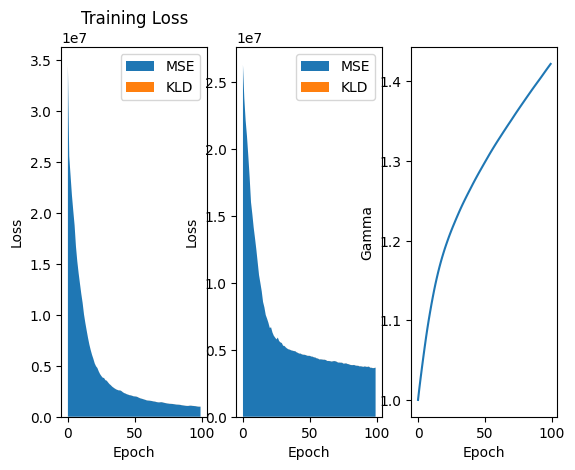

In [17]:
plt.subplot(1,3,1)
plt.stackplot(range(len(t_mse)), t_mse, t_kld, labels=['MSE', 'KLD'])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.subplot(1,3,2)
plt.stackplot(range(len(v_mse)), v_mse, v_kld, labels=['MSE', 'KLD'])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,3,3)
plt.plot(gamma_vals)
plt.xlabel('Epoch')
plt.ylabel('Gamma')
plt.show()


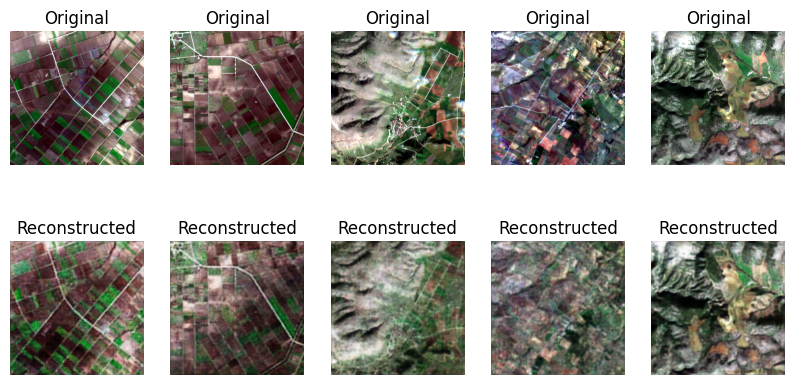

In [18]:
data = next(iter(val_loader))

data = data.to(device)
recon_batch, mu, logvar = model(data)
recon_batch = recon_batch.cpu().detach().numpy()
data = data.cpu().detach().numpy()

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(data[i, bands, :, :].transpose(1, 2, 0))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(recon_batch[i, bands, :, :].transpose(1, 2, 0))
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()



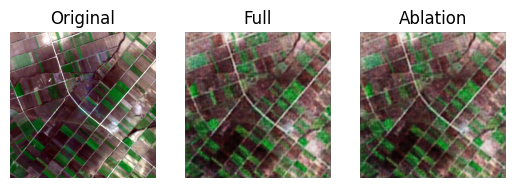

In [21]:
torch.cuda.empty_cache()
mu, logvar = model.encode(torch.Tensor(data[0:1]).to(device))
import numpy as np
mu, logvar = mu.cpu().detach().numpy(), logvar.cpu().detach().numpy()
# Generate batch without ablation
z_no_ablation = torch.Tensor(np.random.normal(loc=mu, scale=np.exp(logvar), size=(500,1024))).to(device)

recon_no_ablation = model.decode(z_no_ablation)
recon_no_ablation = recon_no_ablation.cpu().detach().numpy()


z_no_ablation = z_no_ablation.cpu()
z_ablation = torch.Tensor(z_no_ablation).clone().to(device)
del z_no_ablation

# Generate batch with ablation
z_ablation[:, 64:127] = 0
z_ablation = z_ablation.to(device)
recon_ablation = model.decode(z_ablation)
recon_ablation = recon_ablation.cpu().detach().numpy()

plt.subplot(1,3,1)
plt.imshow(data[0,bands,:,:].transpose(1, 2, 0))
plt.title("Original")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(recon_no_ablation[0,bands,:,:].transpose(1, 2, 0))
plt.title("Full")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(recon_ablation[0,bands,:,:].transpose(1, 2, 0))
plt.title("Ablation")
plt.axis('off')

plt.show()


err_map = np.var(data[0:1] - recon_no_ablation, axis=0)
err_map = np.mean(err_map, axis=0)

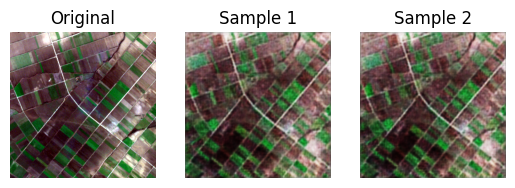

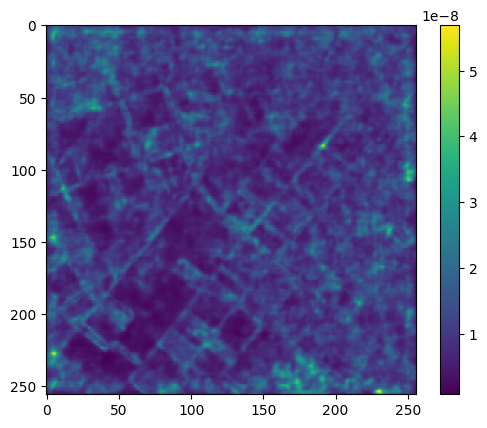

In [22]:
plt.subplot(1,3,1)
plt.imshow(data[0,bands,:,:].transpose(1, 2, 0))
plt.title("Original")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(recon_no_ablation[0,bands,:,:].transpose(1, 2, 0))
plt.title("Sample 1")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(recon_no_ablation[1,bands,:,:].transpose(1, 2, 0))
plt.title("Sample 2")
plt.axis('off')

plt.show()

plt.imshow(err_map)
plt.colorbar()
plt.show()

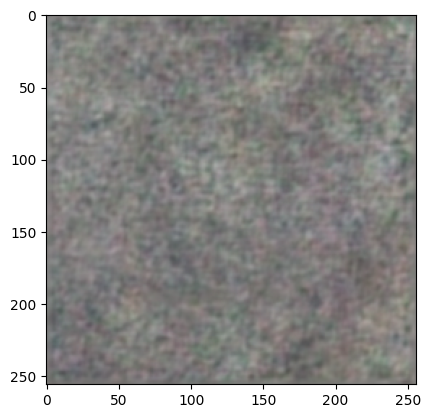

In [23]:
z_sample = torch.Tensor(np.random.randn(1,1024)).to(device)
decod = model.decode(z_sample)

plt.imshow(decod[0,bands,:,:].cpu().detach().numpy().transpose(1, 2, 0))
plt.show()